In [1]:
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
# import mpld3 
import seaborn as sns
import palettable.colorbrewer.diverging as pld

import numpy as np
import pandas as pd
from sklearn import preprocessing

from scipy import integrate  
#import scipy.signal as scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

%matplotlib widget

In [2]:
plt.close('all')

In [3]:
## Plotting parameters

palette = pld.RdYlGn_4_r
cmap = palette.mpl_colormap
transparency = 0.7
labelsize = 20
spinewidth = 3
fontsize = 26
legendsize = 20
fontweight = 'bold'
labelpad = 6
pad = 10
linewidth = 2.5


# Import analysis functions

In [4]:
%run -i /Users/chenghunglin/Documents/Git_BNL/profile_collection_ldrd20-31/scripts/_data_analysis.py

# Read Uv-Vis data in .csv

## Find the subfolders in the current working folder (cwd)

In [5]:
#cwd = os.getcwd()
cwd = '/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20230818_dilute_plqy'
subfolder = glob.glob(cwd + '/CsPbBr**')
subfolder.sort()
# del subfolder_PL[0]
print(*subfolder, sep = '\n')  ## Print one element per line

/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20230818_dilute_plqy/CsPbBr_I_00_6mM
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20230818_dilute_plqy/CsPbBr_I_08_6mM
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/UVVIS_OceanView/20230818_dilute_plqy/CsPbBr_I_64_6mM


In [6]:
len(subfolder)

3

## Read dark and reference

In [7]:
# dark = cwd + '/' + 'Dark_Abs_20221108-154436_dfc6c06b.csv'
# ref = cwd + '/' + 'TOl_OA_Abs_20221108-154443_1f59eee7.csv'

# dark_df = pd.read_csv(dark, skiprows=2, sep=',')
# ref_df = pd.read_csv(ref, skiprows=2, sep=',')

## Define title and label for plotting

In [8]:
title = [os.path.basename(subfolder[i]) for i in range(len(subfolder))]
print(*title, sep='\n')

#title = ['Insitu CsPb 6mM + Br 6 mM',
# title = ['Insitu CsPb 6mM + Br 6 mM + ZnI2 8uL/min', 
#          'Insitu CsPb 6mM + Br 6 mM + ZnI2 16uL/min',
#          'Insitu CsPb 6mM + Br 6 mM + ZnI2 32uL/min', 
#          'Insitu CsPb 6mM + Br 6 mM + ZnI2 64uL/min']
         # 'Insitu CsPb 6mM + Br 6 mM + ZnI2 128uL/min']

#label = ['CsPbBr',
label = ['ZnI2 8 uL/min', 
         'ZnI2 16 uL/min',
         'ZnI2 32 uL/min',
         'ZnI2 64 uL/min']
         # 'ZnI2 128 uL/min']

CsPbBr_I_00_6mM
CsPbBr_I_08_6mM
CsPbBr_I_64_6mM


## Use file name to calculate dilute concentration

In [9]:
dilute_fraction = ['0.00', '0.25', '0.50', '1.00']
chemical_ids = ['Cs_', 'Br_', 'I_', 'Tol_']


dilute = {}                                             ## make an empty dic for store all dilute conditions
dilute_unique = {}                                      ## make an empty dic for find unique values in all dilute conditions
Tol = {}                                                ## make an empty dic for store Tol_OA rates in all dilute conditions
Tol_unique = {}                                         ## make an empty dic for find unique Tol_OA rates in all dilute conditions

for i in range(len(subfolder)):
    dilute[os.path.basename(subfolder[i])] = []         ## use folder names as dic keys
    Tol[os.path.basename(subfolder[i])] = []            ## use folder names as dic keys
    data_files = glob.glob(subfolder[i] + '/**.txt')
    data_files.sort()
    for j in range(len(data_files)):
        data_fn = os.path.basename(data_files[j])
        rate_temp = []
        
        for k in range(len(chemical_ids)):
            rate_id_in_fn = data_fn.index(chemical_ids[k]) + len(chemical_ids[k])
            pump_rate = float(data_fn[rate_id_in_fn:rate_id_in_fn+3])
            rate_temp.append(pump_rate)
            if chemical_ids[k] == 'Tol_':
                Tol[os.path.basename(subfolder[i])].append(data_fn[rate_id_in_fn:rate_id_in_fn+3])
        
        dilute_fraction = rate_temp[-1] / sum(rate_temp[:-1])
        dilute[os.path.basename(subfolder[i])].append(dilute_fraction)
    
    dilute_unique[os.path.basename(subfolder[i])] = np.unique(dilute[os.path.basename(subfolder[i])])
    Tol_unique[os.path.basename(subfolder[i])] = np.unique(Tol[os.path.basename(subfolder[i])])


In [10]:
dilute_unique

{'CsPbBr_I_00_6mM': array([0.  , 0.25, 0.5 , 1.  , 2.  ]),
 'CsPbBr_I_08_6mM': array([0.  , 0.25, 0.5 , 1.  ]),
 'CsPbBr_I_64_6mM': array([0.  , 0.25, 0.5 , 1.  ])}

In [11]:
Tol_unique

{'CsPbBr_I_00_6mM': array(['000', '050', '100', '200', '400'], dtype='<U3'),
 'CsPbBr_I_08_6mM': array(['000', '052', '104', '208'], dtype='<U3'),
 'CsPbBr_I_64_6mM': array(['000', '066', '132', '264'], dtype='<U3')}

## Plot all fluorescence data and put avergae into pd.Dataframe()

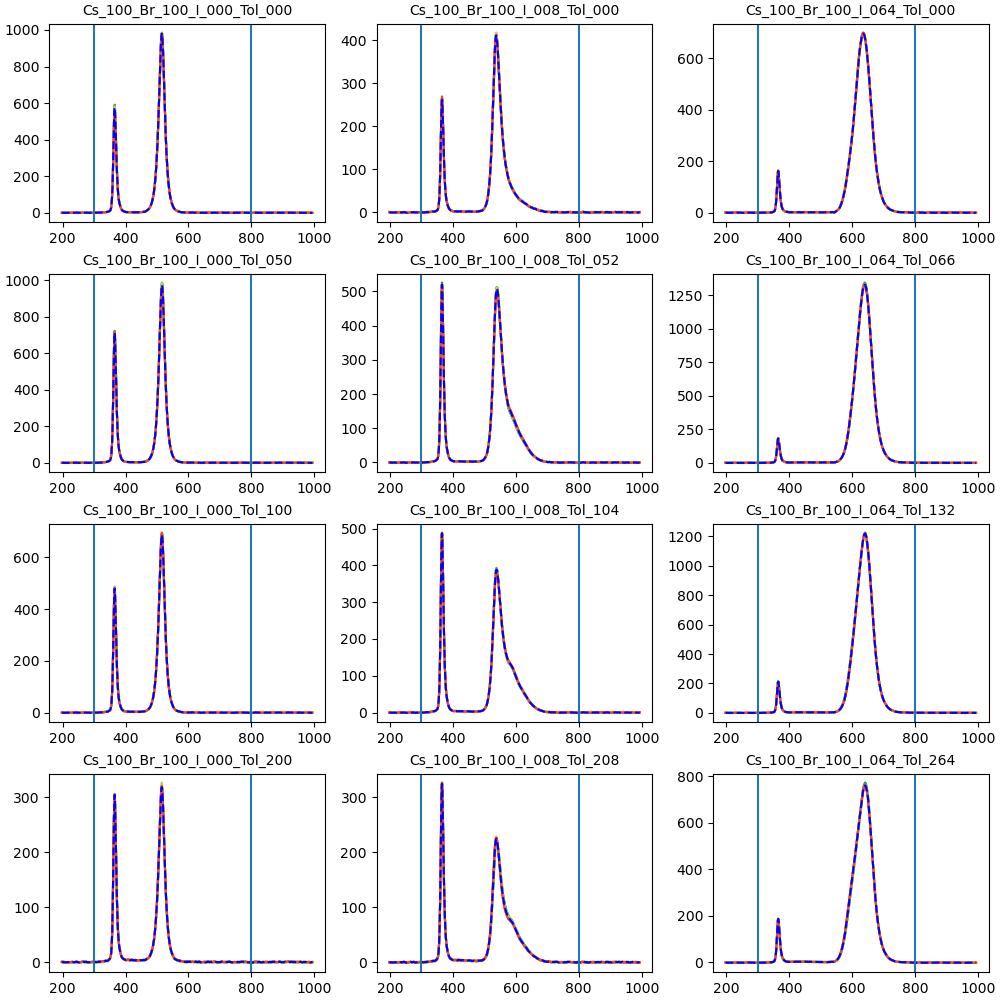

In [12]:
rows = 4
cols = 3
f1, ax1 = plt.subplots(rows, cols, figsize = (10, 10), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

# ax1 = ax1.flatten()
df = pd.DataFrame()
# df_norm = pd.DataFrame()
df_norm2 = pd.DataFrame()

## Wavelength range
wl1 = 300
wl2 = 800

skiprows = 14 ## skip 23 rows if data processed by dioptas or ## 8
sep = '\t'
# for i in range(len(subfolder)):
for i in range(cols):
    for j in range(rows):
        Tol_rate = Tol_unique[os.path.basename(subfolder[i])][j]
        data_files = glob.glob(subfolder[i] + f'/**{Tol_rate}_Subt**.txt')
        data_files.sort()
        # del data_files[-1]
    
        ## Data file range
        k1 = 0
        k2 = len(data_files)
        color_idx = np.linspace(0, 1, k2-k1+1)
        
        ss = os.path.basename(data_files[0]).index('Subt')-1
        suffix = os.path.basename(data_files[0])[:ss]
        ax1[j][i].set_title(suffix, {'fontsize': 10, 'fontweight': 'normal'})
     
        df_temp = pd.DataFrame()
        df_int = pd.DataFrame()
   
        ### plot every scan in subplots
        for k in range(len(data_files)):        
            df_temp = pd.read_csv(data_files[k], skiprows=skiprows, sep=sep, names = ['Wavelength', f'{suffix}_{k:03d}'])
            # df_temp = pd.concat([df_temp, df[f'{suffix[id0:id1]}'], axis=1, ignore_index=False)
            df_int = pd.concat([df_int, df_temp[f'{suffix}_{k:03d}']], axis=1, ignore_index=False)
            ax1[j][i].plot(df_temp['Wavelength'], df_temp[f'{suffix}_{k:03d}'], color=cmap(color_idx[k]),) #label=f'{title}_{k:03d}')      
        df_int[f'{suffix}_mean'] = df_int.mean(axis=1)
        # ax1[j][i].legend()
        ax1[j][i].plot(df_temp['Wavelength'], df_int[f'{suffix}_mean'], 'b--')

        ### Put average data into df
        df[f'x_{suffix}'] = df_temp['Wavelength']
        df[f'{suffix}_mean'] = df_int[f'{suffix}_mean']


        ### Plot vertical lines to show nromalized range
        idx1, w1 = find_nearest(df[f'x_{suffix}'], wl1)
        idx2, w2 = find_nearest(df[f'x_{suffix}'], wl2)
        ax1[j][i].axvline(w1)
        ax1[j][i].axvline(w2)

        ### Put normalized average data into df_norm2
        x = df[f'{suffix}_mean'].loc[idx1:idx2].values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
        df_norm2[f'x_{suffix}'] = df[f'x_{suffix}'].loc[idx1:idx2].values
        df_norm2[f'{suffix}_mean']= x_scaled.flatten()

        # ax1[i].set_xlim(200, 900)
        # # ax1[i].set_ylim(-0.1, max(PL[100:800])+0.2)
        # ax1[i].tick_params(axis='both', direction='in', labelsize=6)


### Define keys for df

In [13]:
keys_list = list(df.keys())
# k1 = [k for k in keys_list if 'mean' in k]
keys_list

['x_Cs_100_Br_100_I_000_Tol_000',
 'Cs_100_Br_100_I_000_Tol_000_mean',
 'x_Cs_100_Br_100_I_000_Tol_050',
 'Cs_100_Br_100_I_000_Tol_050_mean',
 'x_Cs_100_Br_100_I_000_Tol_100',
 'Cs_100_Br_100_I_000_Tol_100_mean',
 'x_Cs_100_Br_100_I_000_Tol_200',
 'Cs_100_Br_100_I_000_Tol_200_mean',
 'x_Cs_100_Br_100_I_008_Tol_000',
 'Cs_100_Br_100_I_008_Tol_000_mean',
 'x_Cs_100_Br_100_I_008_Tol_052',
 'Cs_100_Br_100_I_008_Tol_052_mean',
 'x_Cs_100_Br_100_I_008_Tol_104',
 'Cs_100_Br_100_I_008_Tol_104_mean',
 'x_Cs_100_Br_100_I_008_Tol_208',
 'Cs_100_Br_100_I_008_Tol_208_mean',
 'x_Cs_100_Br_100_I_064_Tol_000',
 'Cs_100_Br_100_I_064_Tol_000_mean',
 'x_Cs_100_Br_100_I_064_Tol_066',
 'Cs_100_Br_100_I_064_Tol_066_mean',
 'x_Cs_100_Br_100_I_064_Tol_132',
 'Cs_100_Br_100_I_064_Tol_132_mean',
 'x_Cs_100_Br_100_I_064_Tol_264',
 'Cs_100_Br_100_I_064_Tol_264_mean']

## Plot average PL profiles in df

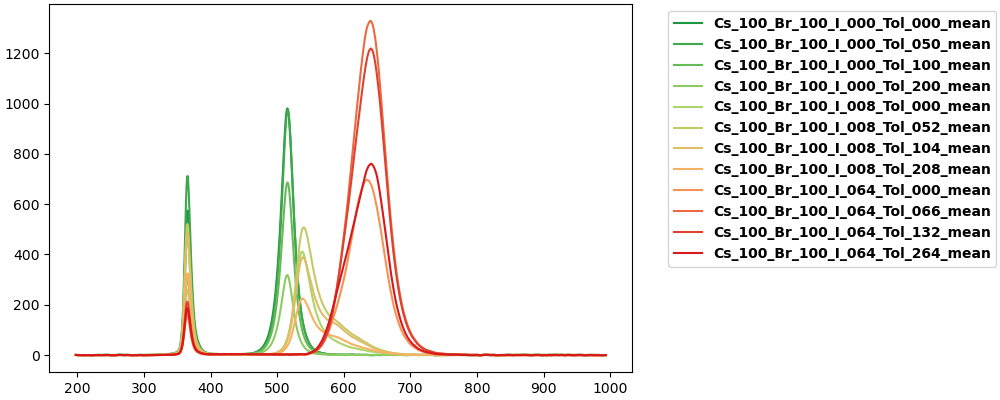

In [14]:
f2, ax2 = plt.subplots(1, 1, figsize = (10, 4), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

k = len(keys_list[1::2])
color_idx = np.linspace(0, 1, k)
for i in range(len(keys_list[1::2])):
    #ax2.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax2.plot(df[keys_list[i*2]], df[keys_list[i*2+1]], color=cmap(color_idx[i]), label=keys_list[1::2][i])

legend_properties = {'weight':'bold', 'size':10}    
ax2.legend(fontsize=legendsize, prop=legend_properties, bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)

## Plot normalized PL profiles in df_norm2

In [15]:
'''
f3, ax3 = plt.subplots(1, 1, figsize = (6, 4), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

k = len(subfolder_PL)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder_PL)):
    #ax3.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax3.plot(df_norm2[keys_list[i*2]], df_norm2[keys_list[i*2+1]], color=cmap(color_idx[i]), label=label[i])

legend_properties = {'weight':'bold', 'size':12}    
ax3.legend(fontsize=legendsize, prop=legend_properties)
'''

"\nf3, ax3 = plt.subplots(1, 1, figsize = (6, 4), constrained_layout=True)\n# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})\n\nk = len(subfolder_PL)\ncolor_idx = np.linspace(0, 1, k)\nfor i in range(len(subfolder_PL)):\n    #ax3.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})\n    ax3.plot(df_norm2[keys_list[i*2]], df_norm2[keys_list[i*2+1]], color=cmap(color_idx[i]), label=label[i])\n\nlegend_properties = {'weight':'bold', 'size':12}    \nax3.legend(fontsize=legendsize, prop=legend_properties)\n"

## Gaussian peak fittimg

Cs_100_Br_100_I_000_Tol_000_mean passes c1 so is good.

** Average of Cs_100_Br_100_I_000_Tol_000_mean has peaks at [148]**


** start to do peak fitting by Gaussian**

Cs_100_Br_100_I_000_Tol_000_mean passes c1 so is good.

** Average of Cs_100_Br_100_I_000_Tol_000_mean has peaks at [149]**


** start to do peak fitting by Gaussian**

Cs_100_Br_100_I_000_Tol_000_mean passes c1 so is good.

** Average of Cs_100_Br_100_I_000_Tol_000_mean has peaks at [148]**


** start to do peak fitting by Gaussian**

Cs_100_Br_100_I_000_Tol_000_mean passes c1 so is good.

** Average of Cs_100_Br_100_I_000_Tol_000_mean has peaks at [148]**


** start to do peak fitting by Gaussian**

Cs_100_Br_100_I_000_Tol_050_mean passes c1 so is good.

** Average of Cs_100_Br_100_I_000_Tol_050_mean has peaks at [177]**


** start to do peak fitting by Gaussian**

Cs_100_Br_100_I_000_Tol_050_mean passes c1 so is good.

** Average of Cs_100_Br_100_I_000_Tol_050_mean has peaks at [180]**


** start to do peak fitting b

"\n# abs_365 = np.asarray([0.458828, 0.373916, 0.656800, 1.052980, 1.582505, 1.302717])\n# abs_365 = np.asarray([0.45788178937234225, 0.906788585562671, 1.3468533683956367, 1.8042517715092394, 2.0145695678124844])\nabs_365 = np.asarray([0.906788585562671, 1.3468533683956367, 1.8042517715092394, 2.0145695678124844])\nabs_365_r = 0.376390\nplqy_r = 0.546\nref_idx_toluene = 1.506\nref_idx_H2SO4 = 1.337\nintegral_r = 468573.0\nintegral_pqds = np.asarray(simpson_int)\n\nplqy = plqy_r*abs_365_r*(ref_idx_toluene**2)*integral_pqds / (integral_r*(ref_idx_H2SO4**2)*abs_365)\n    \nf5, ax5 = plt.subplots(1, 3, figsize = (12, 4), constrained_layout=True)\nax5[0].set_title('Emission Peak')\nax5[0].plot([8,16,32,64], peak_list, '.--', markersize=10)\nax5[0].set_xlabel(r'$ZnI_2\\ rate\\ (\\mu L/min)$', fontdict={'size': 10})\nax5[0].set_ylabel('Emission Peak (nm)')\n\nax5[1].set_title('FWHM')\nax5[1].plot([8,16,32,64], fwhm, 'g+--', markersize=12)\nax5[1].set_xlabel(r'$ZnI_2\\ rate\\ (\\mu L/min)$', 

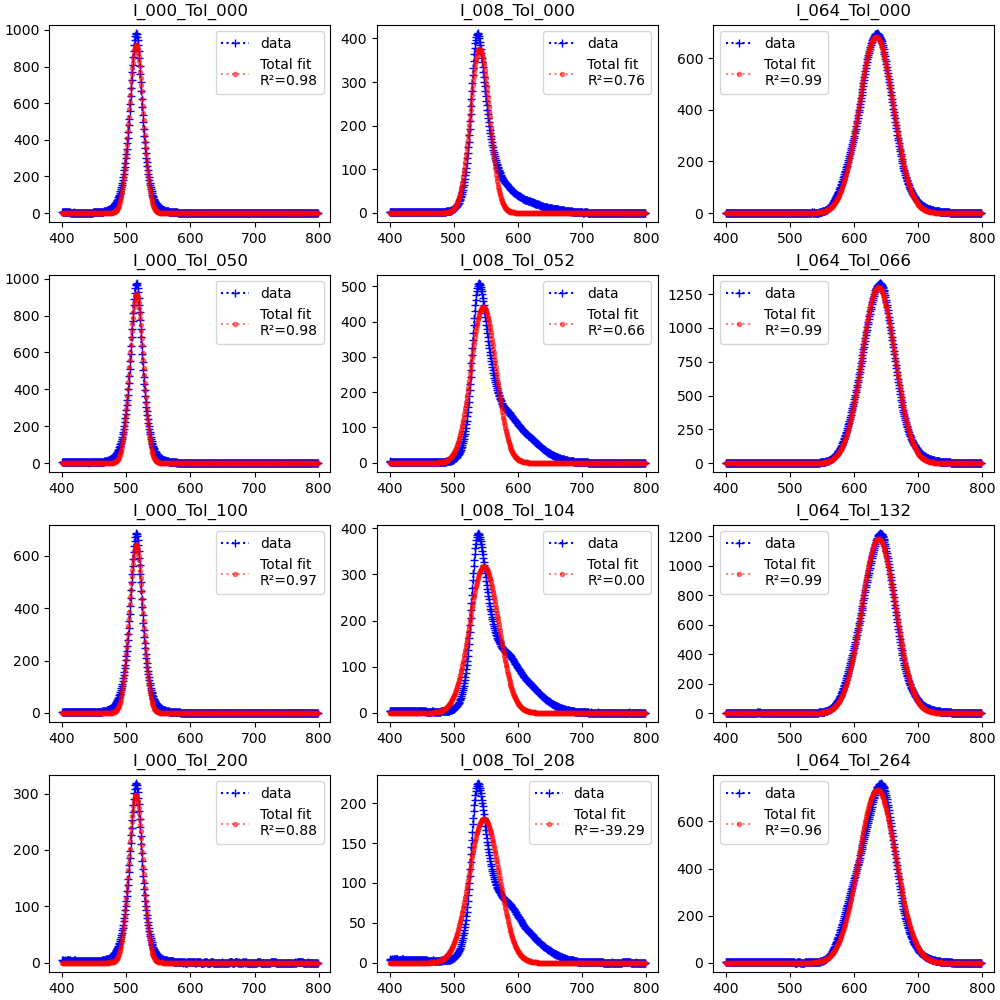

In [16]:
rows = 4
cols = 3
f4, ax4 = plt.subplots(rows, cols, figsize = (10, 10), constrained_layout=True)
# ax4 = ax4.flatten()
wl1 = 400
wl2 = 800
idx1, w1 = find_nearest(df[keys_list[0]], wl1)
idx2, w2 = find_nearest(df[keys_list[0]], wl2)

key_x_reshape = np.asarray(keys_list[0::2]).reshape(cols, rows).T
key_y_reshape = np.asarray(keys_list[1::2]).reshape(cols, rows).T

peak_list = []
fwhm = []
simpson_int = []

for i in range(cols):
    for j in range(rows):
        #i = 4
        x0 = df[key_x_reshape[j][i]][idx1:idx2].to_numpy()
        y0 = df[key_y_reshape[j][i]][idx1:idx2].to_numpy()
        #_2peak_fit_PL(x,y, distr='G', height=1000, second_peak=-4, plot=True, plot_title=os.path.basename(subfolder[i]))

        peak, prop = good_bad_data(x0, y0, key_height=200, data_id = f'{keys_list[i*2+1]}', distance=20, height=50)
        x, y, p, f, popt = _fitting_in_kafka(x0, y0, f'{keys_list[i*2+1]}', peak, prop)  


        simpson_int.append(integrate.simpson(y,x))
        peak_list.append(popt[1])
        fwhm.append(2.355*popt[2])


        fitted_result = f(x, *popt)
        r_2 = r_square(x, y, fitted_result)
        r2 = f'R\u00b2={r_2:.2f}'
        ax4[j][i].set_title(key_y_reshape[j][i][14:27])
        ax4[j][i].plot(x,y,'b+:',label='data')
        ax4[j][i].plot(x,fitted_result,'ro:',label='Total fit\n'+r2, alpha=0.5, markersize=3)

    #     # peak 1
    #     peak_1 = _1gauss(x, *popt[0:3])
    #     ax4[i].plot(x, peak_1, "g", label='peak 1')
    #     ax4[i].fill_between(x, peak_1.min(), peak_1, facecolor="green", alpha=0.5)

    #     # peak 2
    #     peak_2 = _1gauss(x, *popt[3:6])
    #     ax4[i].plot(x, peak_2, "y", label='peak 2')
    #     ax4[i].fill_between(x, peak_2.min(), peak_2, facecolor="yellow", alpha=0.5)

        ax4[j][i].legend()

'''
# abs_365 = np.asarray([0.458828, 0.373916, 0.656800, 1.052980, 1.582505, 1.302717])
# abs_365 = np.asarray([0.45788178937234225, 0.906788585562671, 1.3468533683956367, 1.8042517715092394, 2.0145695678124844])
abs_365 = np.asarray([0.906788585562671, 1.3468533683956367, 1.8042517715092394, 2.0145695678124844])
abs_365_r = 0.376390
plqy_r = 0.546
ref_idx_toluene = 1.506
ref_idx_H2SO4 = 1.337
integral_r = 468573.0
integral_pqds = np.asarray(simpson_int)

plqy = plqy_r*abs_365_r*(ref_idx_toluene**2)*integral_pqds / (integral_r*(ref_idx_H2SO4**2)*abs_365)
    
f5, ax5 = plt.subplots(1, 3, figsize = (12, 4), constrained_layout=True)
ax5[0].set_title('Emission Peak')
ax5[0].plot([8,16,32,64], peak_list, '.--', markersize=10)
ax5[0].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[0].set_ylabel('Emission Peak (nm)')

ax5[1].set_title('FWHM')
ax5[1].plot([8,16,32,64], fwhm, 'g+--', markersize=12)
ax5[1].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[1].set_ylabel('FWHM (nm)')

ax5[2].set_title('PLQY')
ax5[2].plot([8,16,32,64], plqy, 'ro--', markersize=8)
ax5[2].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[2].set_ylabel('PLQY')
'''

## Plot all absorbance data and put avergae into pd.Dataframe()

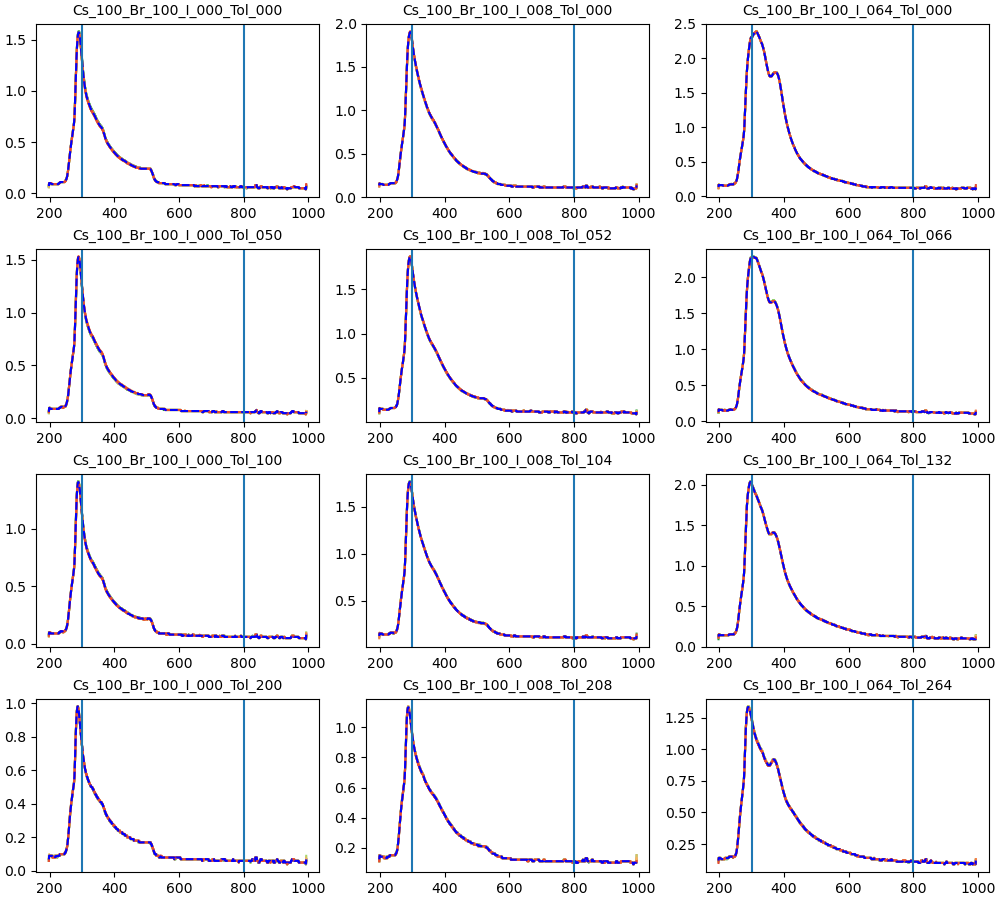

In [17]:
rows = 4
cols = 3
f11, ax11 = plt.subplots(rows, cols, figsize = (10, 9), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

# ax1 = ax1.flatten()
df11 = pd.DataFrame()
# df_norm = pd.DataFrame()
df_norm21 = pd.DataFrame()

## Wavelength range
wl1 = 300
wl2 = 800

skiprows = 14 ## skip 23 rows if data processed by dioptas or ## 8
sep = '\t'
# for i in range(len(subfolder)):
for i in range(cols):
    for j in range(rows):
        Tol_rate = Tol_unique[os.path.basename(subfolder[i])][j]
        data_files = glob.glob(subfolder[i] + f'/**{Tol_rate}_Absor**.txt')
        data_files.sort()
        # del data_files[-1]
    
        ## Data file range
        k1 = 0
        k2 = len(data_files)
        color_idx = np.linspace(0, 1, k2-k1+1)
        
        ss = os.path.basename(data_files[0]).index('Absor')-1
        suffix = os.path.basename(data_files[0])[:ss]
        ax11[j][i].set_title(suffix, {'fontsize': 10, 'fontweight': 'normal'})
     
        df_temp = pd.DataFrame()
        df_int = pd.DataFrame()
   
        ### plot every scan in subplots
        for k in range(len(data_files)):        
            df_temp = pd.read_csv(data_files[k], skiprows=skiprows, sep=sep, names = ['Wavelength', f'{suffix}_{k:03d}'])
            # df_temp = pd.concat([df_temp, df[f'{suffix[id0:id1]}'], axis=1, ignore_index=False)
            df_int = pd.concat([df_int, df_temp[f'{suffix}_{k:03d}']], axis=1, ignore_index=False)
            ax11[j][i].plot(df_temp['Wavelength'], df_temp[f'{suffix}_{k:03d}'], color=cmap(color_idx[k]),) #label=f'{title}_{k:03d}')      
        df_int[f'{suffix}_mean'] = df_int.mean(axis=1)
        # ax1[j][i].legend()
        ax11[j][i].plot(df_temp['Wavelength'], df_int[f'{suffix}_mean'], 'b--')

        ### Put average data into df
        df11[f'x_{suffix}'] = df_temp['Wavelength']
        df11[f'{suffix}_mean'] = df_int[f'{suffix}_mean']


        ### Plot vertical lines to show nromalized range
        idx1, w1 = find_nearest(df[f'x_{suffix}'], wl1)
        idx2, w2 = find_nearest(df[f'x_{suffix}'], wl2)
        ax11[j][i].axvline(w1)
        ax11[j][i].axvline(w2)

        ### Put normalized average data into df_norm2
        x = df[f'{suffix}_mean'].loc[idx1:idx2].values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
        df_norm21[f'x_{suffix}'] = df[f'x_{suffix}'].loc[idx1:idx2].values
        df_norm21[f'{suffix}_mean']= x_scaled.flatten()

        # ax1[i].set_xlim(200, 900)
        # # ax1[i].set_ylim(-0.1, max(PL[100:800])+0.2)
        # ax1[i].tick_params(axis='both', direction='in', labelsize=6)

In [18]:
df11

,x_Cs_100_Br_100_I_000_Tol_000,Cs_100_Br_100_I_000_Tol_000_mean,x_Cs_100_Br_100_I_000_Tol_050,Cs_100_Br_100_I_000_Tol_050_mean,x_Cs_100_Br_100_I_000_Tol_100,Cs_100_Br_100_I_000_Tol_100_mean,x_Cs_100_Br_100_I_000_Tol_200,Cs_100_Br_100_I_000_Tol_200_mean,x_Cs_100_Br_100_I_008_Tol_000,Cs_100_Br_100_I_008_Tol_000_mean,...,x_Cs_100_Br_100_I_008_Tol_208,Cs_100_Br_100_I_008_Tol_208_mean,x_Cs_100_Br_100_I_064_Tol_000,Cs_100_Br_100_I_064_Tol_000_mean,x_Cs_100_Br_100_I_064_Tol_066,Cs_100_Br_100_I_064_Tol_066_mean,x_Cs_100_Br_100_I_064_Tol_132,Cs_100_Br_100_I_064_Tol_132_mean,x_Cs_100_Br_100_I_064_Tol_264,Cs_100_Br_100_I_064_Tol_264_mean
0,197.742,0.071111,197.742,0.062222,197.742,0.078889,197.742,0.068889,197.742,0.134444,...,197.742,0.122222,197.742,0.131111,197.742,0.132222,197.742,0.121111,197.742,0.118889
1,198.544,0.100000,198.544,0.098889,198.544,0.098889,198.544,0.091111,198.544,0.156667,...,198.544,0.146667,198.544,0.164444,198.544,0.166667,198.544,0.145556,198.544,0.140000
2,199.347,0.100000,199.347,0.098889,199.347,0.096667,199.347,0.090000,199.347,0.150000,...,199.347,0.147778,199.347,0.161111,199.347,0.161111,199.347,0.145556,199.347,0.140000
3,200.149,0.100000,200.149,0.096667,200.149,0.095556,200.149,0.090000,200.149,0.150000,...,200.149,0.145556,200.149,0.160000,200.149,0.160000,200.149,0.143333,200.149,0.140000
4,200.951,0.097778,200.951,0.095556,200.951,0.094444,200.951,0.090000,200.951,0.150000,...,200.951,0.141111,200.951,0.160000,200.951,0.160000,200.951,0.142222,200.951,0.138889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,990.770,0.050000,990.770,0.050000,990.770,0.050000,990.770,0.050000,990.770,0.100000,...,990.770,0.100000,990.770,0.110000,990.770,0.100000,990.770,0.090000,990.770,0.090000
1040,991.489,0.040000,991.489,0.040000,991.489,0.050000,991.489,0.050000,991.489,0.100000,...,991.489,0.100000,991.489,0.110000,991.489,0.100000,991.489,0.090000,991.489,0.090000
1041,992.208,0.040000,992.208,0.040000,992.208,0.040000,992.208,0.045556,992.208,0.100000,...,992.208,0.100000,992.208,0.100000,992.208,0.100000,992.208,0.090000,992.208,0.090000
1042,992.928,0.040000,992.928,0.040000,992.928,0.040000,992.928,0.042222,992.928,0.100000,...,992.928,0.100000,992.928,0.100000,992.928,0.100000,992.928,0.090000,992.928,0.090000


In [19]:
keys_list2 = list(df11.keys())
# k1 = [k for k in keys_list if 'mean' in k]
keys_list2

['x_Cs_100_Br_100_I_000_Tol_000',
 'Cs_100_Br_100_I_000_Tol_000_mean',
 'x_Cs_100_Br_100_I_000_Tol_050',
 'Cs_100_Br_100_I_000_Tol_050_mean',
 'x_Cs_100_Br_100_I_000_Tol_100',
 'Cs_100_Br_100_I_000_Tol_100_mean',
 'x_Cs_100_Br_100_I_000_Tol_200',
 'Cs_100_Br_100_I_000_Tol_200_mean',
 'x_Cs_100_Br_100_I_008_Tol_000',
 'Cs_100_Br_100_I_008_Tol_000_mean',
 'x_Cs_100_Br_100_I_008_Tol_052',
 'Cs_100_Br_100_I_008_Tol_052_mean',
 'x_Cs_100_Br_100_I_008_Tol_104',
 'Cs_100_Br_100_I_008_Tol_104_mean',
 'x_Cs_100_Br_100_I_008_Tol_208',
 'Cs_100_Br_100_I_008_Tol_208_mean',
 'x_Cs_100_Br_100_I_064_Tol_000',
 'Cs_100_Br_100_I_064_Tol_000_mean',
 'x_Cs_100_Br_100_I_064_Tol_066',
 'Cs_100_Br_100_I_064_Tol_066_mean',
 'x_Cs_100_Br_100_I_064_Tol_132',
 'Cs_100_Br_100_I_064_Tol_132_mean',
 'x_Cs_100_Br_100_I_064_Tol_264',
 'Cs_100_Br_100_I_064_Tol_264_mean']

In [20]:
idx_365, w365 = find_nearest(df11[keys_list2[0]], 365)
df11.iloc[idx_365][::-2][::-1].to_list()
idx_365

210

In [21]:
df11.iloc[210:220]

,x_Cs_100_Br_100_I_000_Tol_000,Cs_100_Br_100_I_000_Tol_000_mean,x_Cs_100_Br_100_I_000_Tol_050,Cs_100_Br_100_I_000_Tol_050_mean,x_Cs_100_Br_100_I_000_Tol_100,Cs_100_Br_100_I_000_Tol_100_mean,x_Cs_100_Br_100_I_000_Tol_200,Cs_100_Br_100_I_000_Tol_200_mean,x_Cs_100_Br_100_I_008_Tol_000,Cs_100_Br_100_I_008_Tol_000_mean,...,x_Cs_100_Br_100_I_008_Tol_208,Cs_100_Br_100_I_008_Tol_208_mean,x_Cs_100_Br_100_I_064_Tol_000,Cs_100_Br_100_I_064_Tol_000_mean,x_Cs_100_Br_100_I_064_Tol_066,Cs_100_Br_100_I_064_Tol_066_mean,x_Cs_100_Br_100_I_064_Tol_132,Cs_100_Br_100_I_064_Tol_132_mean,x_Cs_100_Br_100_I_064_Tol_264,Cs_100_Br_100_I_064_Tol_264_mean
210,364.721,0.616667,364.721,0.595556,364.721,0.554444,364.721,0.390000,364.721,0.884444,...,364.721,0.552222,364.721,1.760000,364.721,1.666667,364.721,1.403333,364.721,0.911111
211,365.509,0.613333,365.509,0.586667,365.509,0.548889,365.509,0.390000,365.509,0.881111,...,365.509,0.550000,365.509,1.766667,365.509,1.671111,365.509,1.405556,365.509,0.914444
212,366.297,0.603333,366.297,0.581111,366.297,0.543333,366.297,0.380000,366.297,0.874444,...,366.297,0.550000,366.297,1.770000,366.297,1.672222,366.297,1.406667,366.297,0.915556
213,367.085,0.594444,367.085,0.574444,367.085,0.534444,367.085,0.380000,367.085,0.871111,...,367.085,0.547778,367.085,1.777778,367.085,1.674444,367.085,1.408889,367.085,0.918889
214,367.872,0.585556,367.872,0.564444,367.872,0.525556,367.872,0.372222,367.872,0.864444,...,367.872,0.544444,367.872,1.780000,367.872,1.674444,367.872,1.408889,367.872,0.918889
215,368.660,0.577778,368.660,0.555556,368.660,0.521111,368.660,0.370000,368.660,0.861111,...,368.660,0.540000,368.660,1.785556,368.660,1.674444,368.660,1.408889,368.660,0.920000
216,369.447,0.572222,369.447,0.545556,369.447,0.513333,369.447,0.362222,369.447,0.854444,...,369.447,0.540000,369.447,1.788889,369.447,1.672222,369.447,1.406667,369.447,0.918889
217,370.235,0.563333,370.235,0.537778,370.235,0.504444,370.235,0.360000,370.235,0.851111,...,370.235,0.538889,370.235,1.790000,370.235,1.671111,370.235,1.406667,370.235,0.918889
218,371.022,0.553333,371.022,0.528889,371.022,0.494444,371.022,0.354444,371.022,0.843333,...,371.022,0.534444,371.022,1.792222,371.022,1.665556,371.022,1.403333,371.022,0.915556
219,371.809,0.543333,371.809,0.524444,371.809,0.490000,371.809,0.350000,371.809,0.837778,...,371.809,0.530000,371.809,1.794444,371.809,1.662222,371.809,1.398889,371.809,0.915556


## Try linear fitting

In [22]:
def line_2D(x, slope, y_intercept):
    y = x*slope + y_intercept
    return y


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def fit_line_2D(x, y, fit_function, x_range=[500, 900], maxfev=10000, plot=True):
    x = np.asarray(x)
    y = np.asarray(y)
    y = np.nan_to_num(y, nan=0)
    
    try:        
        idx0, _ = find_nearest(x, x_range[0])
        idx1, _ = find_nearest(x, x_range[1])
    except (TypeError, IndexError):
        idx0 = 0
        idx1 = -1
    
    slope = (x[idx1]-x[idx0])/(y[idx1]-y[idx0])
    y_intercept = np.mean(y[idx0:idx1])
    
    try:
        initial_guess = [slope, y_intercept]
    except (TypeError, IndexError):
        initial_guess = [0.01, 0]
    
    try:
        popt, pcov = curve_fit(fit_function, x[idx0:idx1], y[idx0:idx1], p0=initial_guess, maxfev=maxfev)
    except RuntimeError:
        maxfev=1000000
        popt, pcov = curve_fit(fit_function, x[idx0:idx1], y[idx0:idx1], p0=initial_guess, maxfev=maxfev)
        
    if plot:
        plt.figure()
        plt.plot(x, y, label='data')
        plt.plot(x, fit_function(x, popt[0], popt[1]), label=f'y={popt[0]:.4f}x+{popt[1]:.4f}')
        plt.legend()
    
    return popt, pcov


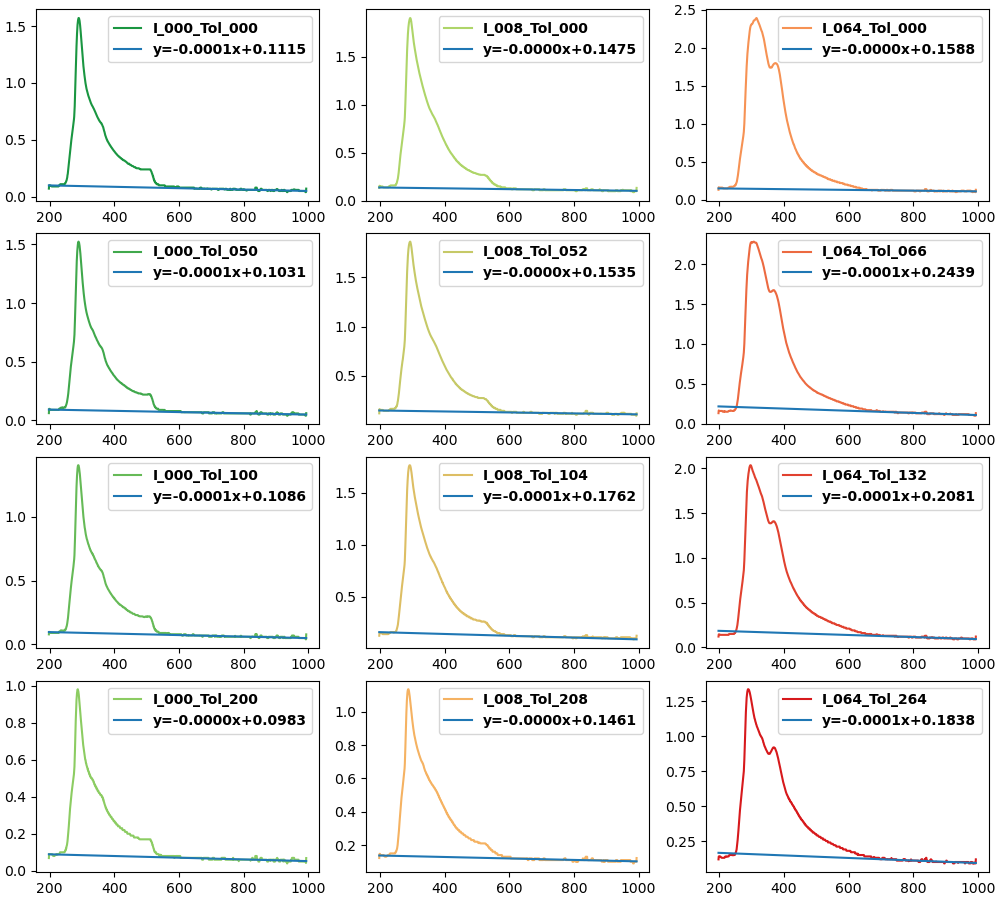

In [23]:
rows = 4
cols = 3
f31, ax31 = plt.subplots(rows, cols, figsize = (10, 9), constrained_layout=True)

title = keys_list2[1::2]
title_reshape = np.asarray(title).reshape(cols, rows).T
color_idx = np.linspace(0, 1, len(title))
id0 = 8
id1 = 22
x_range_list = [[700, 900], [600, 900], [600, 900], 
                [600, 900], [600, 900], [600, 900], 
                [600, 800], [600, 900], [700, 990],
                [800, 990], [800, 990], [800, 990],
               ]

legend_properties = {'weight':'bold', 'size':10}
df12 = pd.DataFrame()
for i in range(len(title)):
    # ax1.plot(df_tth.iloc[:,i], df_int[k1[i]]+offset*i, color=cmap(color_idx[i]), label=label[i])
    idx_ax = np.argwhere(title_reshape==title[i])
    x = df11[keys_list2[i*2]]
    y = df11[keys_list2[i*2+1]]
    popt, pcov = fit_line_2D(x, y, line_2D, x_range=x_range_list[i], plot=False)
    ax31[idx_ax[0][0], idx_ax[0][1]].plot(x, y, color=cmap(color_idx[i]), label=title[i][14:27])
    ax31[idx_ax[0][0], idx_ax[0][1]].plot(x, line_2D(x, popt[0], popt[1]), label=f'y={popt[0]:.4f}x+{popt[1]:.4f}')
    ax31[idx_ax[0][0], idx_ax[0][1]].legend(prop=legend_properties)
    
    df12[keys_list2[i*2]] = x
    # df4[keys_list2[i*2+1]] = y - popt[1]
    df12[keys_list2[i*2+1]] = y - line_2D(x, *popt)

In [24]:
df12.iloc[210][1::2].to_numpy()

array([0.52746362, 0.51184709, 0.46732677, 0.30848751, 0.7530295 ,
       0.72129275, 0.69444157, 0.42218226, 1.61892786, 1.4722061 ,
       1.23748198, 0.7606698 ])

In [25]:
simpson_int

[26873.119003902084,
 26110.183061636395,
 18682.14807272574,
 8837.701161002955,
 16921.37634721481,
 26229.251705560768,
 21334.49974616905,
 12700.651068622969,
 46799.124605569756,
 85846.43350229158,
 79924.64429374255,
 54071.30315578987]

In [26]:
fwhm

[25.402898582865014,
 24.726516773532797,
 25.04214222493104,
 25.40363364185357,
 35.2571519406777,
 46.23604870491549,
 53.57629671977253,
 55.70784587373385,
 63.14493155695542,
 60.747174210811586,
 62.22732970640978,
 68.26718637949388]

## Plot PE, FWHM, PLQY

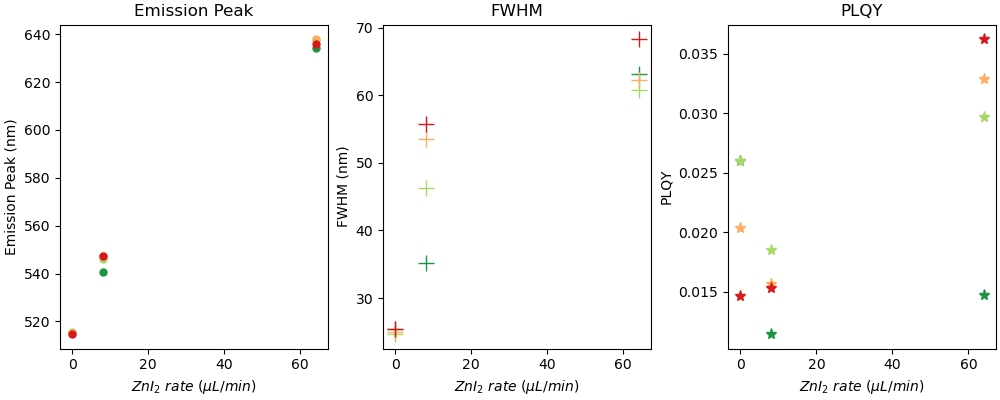

In [27]:
# abs_365 = df11.iloc[210][1::2].to_numpy()
abs_365 = df12.iloc[210][1::2].to_numpy()

abs_365_r = 0.111201
plqy_r = 0.546
ref_idx_toluene = 1.506
ref_idx_H2SO4 = 1.337
integral_r = 151127.098835
integral_pqds = np.asarray(simpson_int)

plqy = plqy_r*abs_365_r*(ref_idx_toluene**2)*integral_pqds / (integral_r*(ref_idx_H2SO4**2)*abs_365)
    

x_list = [0,0,0,0,8,8,8,8,64,64,64,64]
x_list_T = np.asarray(x_list).reshape(cols, rows).T
peak_list_T = np.asarray(peak_list).reshape(cols, rows).T
fwhm_T = np.asarray(fwhm).reshape(cols, rows).T
plqy_T = np.asarray(plqy).reshape(cols, rows).T

rows = 4
cols = 3

f5, ax5 = plt.subplots(1, cols, figsize = (10, 4), constrained_layout=True)
ax5[0].set_title('Emission Peak')
ax5[0].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[0].set_ylabel('Emission Peak (nm)')
ax5[1].set_title('FWHM')
ax5[1].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[1].set_ylabel('FWHM (nm)')
ax5[2].set_title('PLQY')
ax5[2].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[2].set_ylabel('PLQY')

color_idx = np.linspace(0, 1, rows)
for j in range(rows):        
    ax5[0].plot(x_list_T[j], peak_list_T[j], '.', color=cmap(color_idx[j]), markersize=10)
    ax5[1].plot(x_list_T[j], fwhm_T[j], '+', color=cmap(color_idx[j]), markersize=12)
    ax5[2].plot(x_list_T[j], plqy_T[j], '*', color=cmap(color_idx[j]), markersize=8)



In [28]:
plqy

array([0.02596998, 0.02600254, 0.02037756, 0.01460319, 0.01145433,
       0.01853619, 0.01566004, 0.01533459, 0.01473521, 0.02972349,
       0.03292213, 0.03623404])

In [29]:
integral_pqds

array([26873.1190039 , 26110.18306164, 18682.14807273,  8837.701161  ,
       16921.37634721, 26229.25170556, 21334.49974617, 12700.65106862,
       46799.12460557, 85846.43350229, 79924.64429374, 54071.30315579])

In [30]:
abs_365

array([0.52746362, 0.51184709, 0.46732677, 0.30848751, 0.7530295 ,
       0.72129275, 0.69444157, 0.42218226, 1.61892786, 1.4722061 ,
       1.23748198, 0.7606698 ])

In [31]:
6/(dilute_unique['CsPbBr_I_64_6mM']+1)

array([6. , 4.8, 4. , 3. ])

In [32]:
x_list_T = np.asarray(x_list).reshape(cols, rows).T
peak_list_T = np.asarray(peak_list).reshape(cols, rows).T
fwhm_T = np.asarray(fwhm).reshape(cols, rows).T
plqy_T = np.asarray(plqy).reshape(cols, rows).T

In [33]:
x_list_T[0][:]

array([ 0,  8, 64])

## Export CsPbBr3 & CsPbI3 without dilute for PLQY_summary.ipynb

In [34]:
df_66 = pd.DataFrame()

df_66['Wavelength_01'] = df['x_Cs_100_Br_100_I_000_Tol_000']
df_66['CsPbBr3_PL'] = df['Cs_100_Br_100_I_000_Tol_000_mean']
df_66['Wavelength_02'] = df11['x_Cs_100_Br_100_I_000_Tol_000']
df_66['CsPbBr3_Abs'] = df11['Cs_100_Br_100_I_000_Tol_000_mean']

df_66['Wavelength_03'] = df['x_Cs_100_Br_100_I_064_Tol_000']
df_66['CsPbI3_PL'] = df['Cs_100_Br_100_I_064_Tol_000_mean']
df_66['Wavelength_04'] = df11['x_Cs_100_Br_100_I_064_Tol_000']
df_66['CsPbI3_Abs'] = df11['Cs_100_Br_100_I_064_Tol_000_mean']

# df_66.to_csv('20230818_CsPbBr.txt', index=False, sep=' ', float_format='{:.5e}'.format)